# 经典又兼具备趣味性的Kaggle案例[泰坦尼克号问题](https://www.kaggle.com/c/titanic)
大家都熟悉的『Jack and Rose』的故事，豪华游艇倒了，大家都惊恐逃生，可是救生艇的数量有限，无法人人都有，副船长发话了『lady and kid first！』，所以是否获救其实并非随机，而是基于一些背景有rank先后的。<br>
训练和测试数据是一些乘客的个人信息以及存活状况，要尝试根据它生成合适的模型并预测其他人的存活状况。<br>
对，这是一个二分类问题，很多分类算法都可以解决。

In [1]:
import pandas as pd #数据分析
import numpy as np #科学计算
from pandas import Series,DataFrame
from sklearn import metrics
import sklearn
import warnings
warnings.filterwarnings("ignore")

data_train = pd.read_csv("Train.csv")
data_train.columns


Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

**<font color=red>我们看大概有以下这些字段</font>**<br>
PassengerId => 乘客ID<br>
Pclass => 乘客等级(1/2/3等舱位)<br>
Name => 乘客姓名<br>
Sex => 性别<br>
Age => 年龄<br>
SibSp => 堂兄弟/妹个数<br>
Parch => 父母与小孩个数<br>
Ticket => 船票信息<br>
Fare => 票价<br>
Cabin => 客舱<br>
Embarked => 登船港口

In [2]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# 1 观察数据

In [3]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# 2 数据可视化
更好的理解数据 帮助我们从中挖掘出有用的数据信息

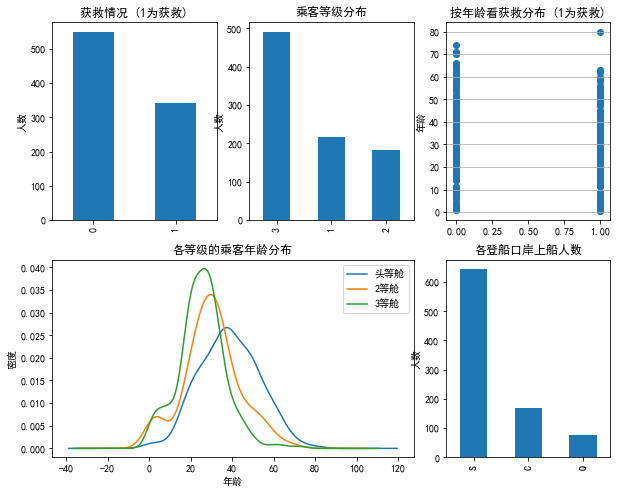

In [22]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.rc('figure',figsize=(10,8))
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False  
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.subplot2grid((2,3),(0,0))             # 在一张大图里分列几个小图
data_train.Survived.value_counts().plot(kind='bar')# plots a bar graph of those who surived vs those who did not. 
plt.title(u"获救情况 (1为获救)") # puts a title on our graph
plt.ylabel(u"人数")  

plt.subplot2grid((2,3),(0,1))
data_train.Pclass.value_counts().plot(kind="bar")
plt.ylabel(u"人数")
plt.title(u"乘客等级分布")

plt.subplot2grid((2,3),(0,2))
plt.scatter(data_train.Survived, data_train.Age)
plt.ylabel(u"年龄")                         # sets the y axis lable
plt.grid(b=True, which='major', axis='y') # formats the grid line style of our graphs
plt.title(u"按年龄看获救分布 (1为获救)")


plt.subplot2grid((2,3),(1,0), colspan=2)
data_train.Age[data_train.Pclass == 1].plot(kind='kde')   # plots a kernel desnsity estimate of the subset of the 1st class passanges's age
data_train.Age[data_train.Pclass == 2].plot(kind='kde')
data_train.Age[data_train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"年龄")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"各等级的乘客年龄分布")
plt.legend((u'头等舱', u'2等舱',u'3等舱'),loc='best') # sets our legend for our graph.


plt.subplot2grid((2,3),(1,2))
data_train.Embarked.value_counts().plot(kind='bar')
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  
plt.show()


于是得到了像下面这样一张图：<br>
![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/8.png)

<Figure size 720x576 with 0 Axes>

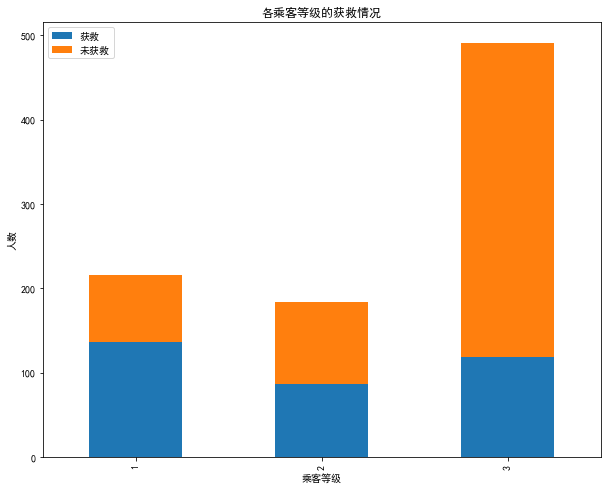

In [5]:
#看看各乘客等级的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Pclass[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Pclass[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"各乘客等级的获救情况")
plt.xlabel(u"乘客等级") 
plt.ylabel(u"人数") 

plt.show()

<Figure size 720x576 with 0 Axes>

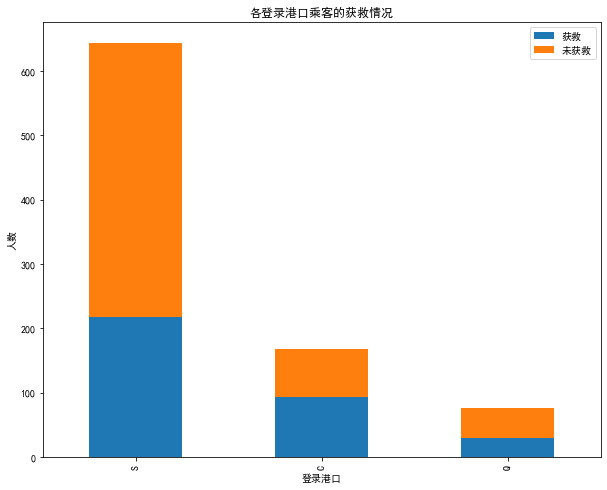

In [6]:
#看看各登录港口的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_0 = data_train.Embarked[data_train.Survived == 0].value_counts()
Survived_1 = data_train.Embarked[data_train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_1, u'未获救':Survived_0})
df.plot(kind='bar', stacked=True)
plt.title(u"各登录港口乘客的获救情况")
plt.xlabel(u"登录港口") 
plt.ylabel(u"人数") 

plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/Embarked.png?imageView/2/w/500/q/100)

<Figure size 720x576 with 0 Axes>

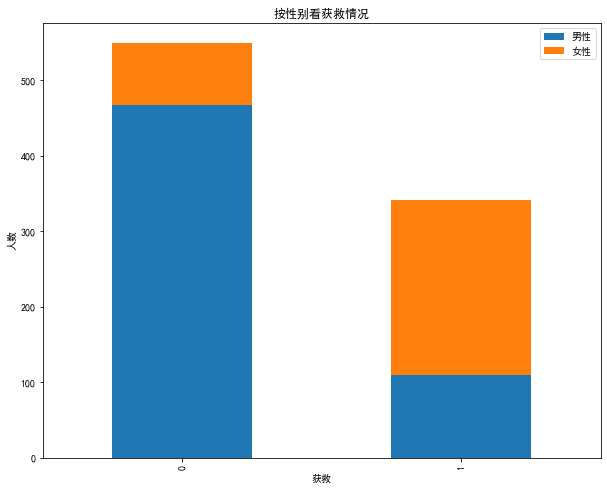

In [23]:
#看看各性别的获救情况
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = data_train.Survived[data_train.Sex == 'male'].value_counts()
Survived_f = data_train.Survived[data_train.Sex == 'female'].value_counts()
df=pd.DataFrame({u'男性':Survived_m, u'女性':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title(u"按性别看获救情况")
plt.xlabel(u"获救") 
plt.ylabel(u"人数")
plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/10.png?imageView/2/w/450/q/100)

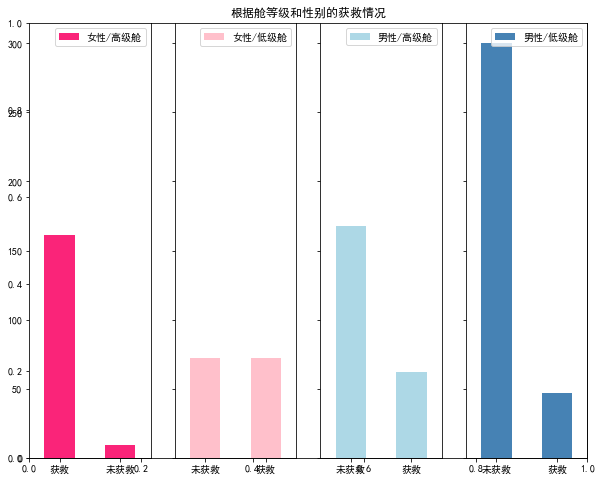

In [8]:
#然后我们再来看看各种舱级别情况下各性别的获救情况
fig=plt.figure()
fig.set(alpha=0.65) # 设置图像透明度，无所谓
plt.title(u"根据舱等级和性别的获救情况")

ax1=fig.add_subplot(141)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass != 3].value_counts().plot(kind='bar', label="female highclass", color='#FA2479')
ax1.set_xticklabels([u"获救", u"未获救"], rotation=0)
ax1.legend([u"女性/高级舱"], loc='best')

ax2=fig.add_subplot(142, sharey=ax1)
data_train.Survived[data_train.Sex == 'female'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='female, low class', color='pink')
ax2.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"女性/低级舱"], loc='best')

ax3=fig.add_subplot(143, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass != 3].value_counts().plot(kind='bar', label='male, high class',color='lightblue')
ax3.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/高级舱"], loc='best')

ax4=fig.add_subplot(144, sharey=ax1)
data_train.Survived[data_train.Sex == 'male'][data_train.Pclass == 3].value_counts().plot(kind='bar', label='male low class', color='steelblue')
ax4.set_xticklabels([u"未获救", u"获救"], rotation=0)
plt.legend([u"男性/低级舱"], loc='best')

plt.show()

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/11.png?imageView/2/w/700/q/100)

In [9]:
g = data_train.groupby(['SibSp','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
df

PassengerId
SibSp Survived             
0     0                 398
      1                 210
1     0                  97
      1                 112
2     0                  15
      1                  13
3     0                  12
      1                   4
4     0                  15
      1                   3
5     0                   5
8     0                   7

In [10]:
g = data_train.groupby(['Parch','Survived'])
df = pd.DataFrame(g.count()['PassengerId'])
df

PassengerId
Parch Survived             
0     0                 445
      1                 233
1     0                  53
      1                  65
2     0                  40
      1                  40
3     0                   2
      1                   3
4     0                   4
5     0                   4
      1                   1
6     0                   1

In [11]:
#ticket是船票编号，应该是unique的，和最后的结果没有太大的关系，不纳入考虑的特征范畴
#cabin只有204个乘客有值，我们先看看它的一个分布
data_train.Cabin.value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
F2             3
D              3
              ..
C128           1
A6             1
D9             1
E46            1
C90            1
Name: Cabin, Length: 147, dtype: int64

<Figure size 720x576 with 0 Axes>

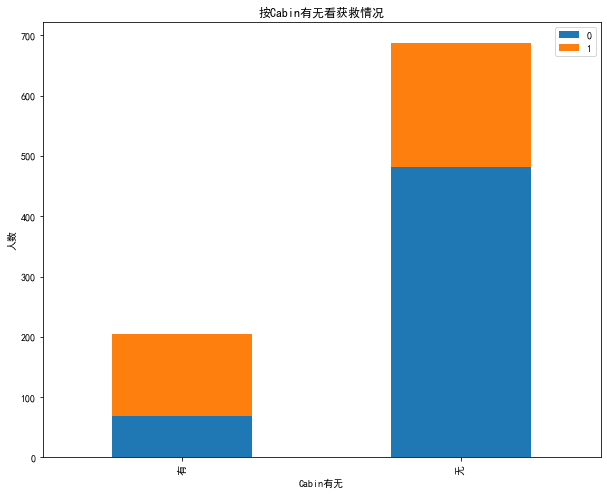

In [12]:
#cabin的值计数太分散了，绝大多数Cabin值只出现一次。感觉上作为类目，加入特征未必会有效
#那我们一起看看这个值的有无，对于survival的分布状况，影响如何吧
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_cabin = data_train.Survived[pd.notnull(data_train.Cabin)].value_counts()
Survived_nocabin = data_train.Survived[pd.isnull(data_train.Cabin)].value_counts()
df=pd.DataFrame({u'有':Survived_cabin, u'无':Survived_nocabin}).transpose()
df.plot(kind='bar', stacked=True)
plt.title(u"按Cabin有无看获救情况")
plt.xlabel(u"Cabin有无") 
plt.ylabel(u"人数")
plt.show()

#似乎有cabin记录的乘客survival比例稍高，那先试试把这个值分为两类，有cabin值/无cabin值，一会儿加到类别特征好了

![](http://7xo0y8.com1.z0.glb.clouddn.com/2_titanic/15.png?imageView/2/w/400/q/100)

<font color=red>有Cabin记录的似乎获救概率稍高一些，先这么着放一放吧。<font><br><br>

<font color=red>先从最突出的数据属性开始吧，对，Cabin和Age，有丢失数据实在是对下一步工作影响太大。<font><br>

<font color=red>先说Cabin，暂时我们就按照刚才说的，按Cabin有无数据，将这个属性处理成Yes和No两种类型吧。<font><br>

<font color=red>再说Age：<font><br>

<font color=red>通常遇到缺值的情况，我们会有几种常见的处理方式<font><br>

1. <font color=red>如果缺值的样本占总数比例极高，我们可能就直接舍弃了，作为特征加入的话，可能反倒带入noise，影响最后的结果了<font><br>
2. <font color=red>如果缺值的样本适中，而该属性非连续值特征属性(比如说类目属性)，那就把NaN作为一个新类别，加到类别特征中<font><br>
3. <font color=red>如果缺值的样本适中，而该属性为连续值特征属性，有时候我们会考虑给定一个step(比如这里的age，我们可以考虑每隔2/3岁为一个步长)，然后把它离散化，之后把NaN作为一个type加到属性类目中。<font><br>
4. <font color=red>有些情况下，缺失的值个数并不是特别多，那我们也可以试着根据已有的值，拟合一下数据，补充上。<font><br>
<font color=red>本例中，后两种处理方式应该都是可行的，我们先试试拟合补全吧(虽然说没有特别多的背景可供我们拟合，这不一定是一个多么好的选择)<font><br>

<font color=red>我们这里用scikit-learn中的RandomForest来拟合一下缺失的年龄数据<font><br>

# 3 缺失值处理
特征工程中很重要的一部分 大家有兴趣上网查阅相关资料

In [13]:
from sklearn.ensemble import RandomForestRegressor
 
### 使用 RandomForestClassifier 填补缺失的年龄属性
def set_missing_ages(df):
    
    # 把已有的数值型特征取出来丢进Random Forest Regressor中
    age_df = df[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]

    # 乘客分成已知年龄和未知年龄两部分
    known_age = age_df.loc[age_df.Age.notnull()].values
    unknown_age = age_df.loc[age_df.Age.isnull()].values

    # y即目标年龄
    y = known_age[:, 0]

    # X即特征属性值
    X = known_age[:, 1:]

    # fit到RandomForestRegressor之中
    rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
    rfr.fit(X, y)
    
    # 用得到的模型进行未知年龄结果预测
    predictedAges = rfr.predict(unknown_age[:, 1::])
    
    # 用得到的预测结果填补原缺失数据
    df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
    return df, rfr

def set_Cabin_type(df):
    df.loc[ (df.Cabin.notnull()), 'Cabin' ] = "Yes"
    df.loc[ (df.Cabin.isnull()), 'Cabin' ] = "No"
    return df

data_train, rfr = set_missing_ages(data_train)
data_train = set_Cabin_type(data_train)
data_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,No,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,Yes,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,No,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,Yes,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,No,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,No,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,Yes,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,16.19395,1,2,W./C. 6607,23.4500,No,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,Yes,C


<font color=red>因为逻辑回归建模时，需要输入的特征都是数值型特征，我们通常会先对类目型的特征因子化/one-hot编码。 <font><br>
<font color=red>什么叫做因子化/one-hot编码？举个例子：<font><br>

<font color=red>以Embarked为例，原本一个属性维度，因为其取值可以是[‘S’,’C’,’Q‘]，而将其平展开为’Embarked_C’,’Embarked_S’, ‘Embarked_Q’三个属性<font><br>

* <font color=red>原本Embarked取值为S的，在此处的”Embarked_S”下取值为1，在’Embarked_C’, ‘Embarked_Q’下取值为0<font><br>
* <font color=red>原本Embarked取值为C的，在此处的”Embarked_C”下取值为1，在’Embarked_S’, ‘Embarked_Q’下取值为0<font><br>
* <font color=red>原本Embarked取值为Q的，在此处的”Embarked_Q”下取值为1，在’Embarked_C’, ‘Embarked_S’下取值为0<font><br>

<font color=red>我们使用pandas的”get_dummies”来完成这个工作，并拼接在原来的”data_train”之上，如下所示。<font><br>

# 4 特征因子化
特征工程中特别重要的一块，主要技术为onehot(独热编码)详细情况大家自行查阅

In [14]:
# 因为逻辑回归建模时，需要输入的特征都是数值型特征
# 我们先对类目型的特征离散/因子化
# 以Cabin为例，原本一个属性维度，因为其取值可以是['yes','no']，而将其平展开为'Cabin_yes','Cabin_no'两个属性
# 原本Cabin取值为yes的，在此处的'Cabin_yes'下取值为1，在'Cabin_no'下取值为0
# 原本Cabin取值为no的，在此处的'Cabin_yes'下取值为0，在'Cabin_no'下取值为1
# 我们使用pandas的get_dummies来完成这个工作，并拼接在原来的data_train之上，如下所示
dummies_Cabin = pd.get_dummies(data_train['Cabin'], prefix= 'Cabin')

dummies_Embarked = pd.get_dummies(data_train['Embarked'], prefix= 'Embarked')

dummies_Sex = pd.get_dummies(data_train['Sex'], prefix= 'Sex')

dummies_Pclass = pd.get_dummies(data_train['Pclass'], prefix= 'Pclass')

df = pd.concat([data_train, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1, inplace=True)
df

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,1,0,22.00000,1,0,7.2500,1,0,0,0,1,0,1,0,0,1
1,2,1,38.00000,1,0,71.2833,0,1,1,0,0,1,0,1,0,0
2,3,1,26.00000,0,0,7.9250,1,0,0,0,1,1,0,0,0,1
3,4,1,35.00000,1,0,53.1000,0,1,0,0,1,1,0,1,0,0
4,5,0,35.00000,0,0,8.0500,1,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.00000,0,0,13.0000,1,0,0,0,1,0,1,0,1,0
887,888,1,19.00000,0,0,30.0000,0,1,0,0,1,1,0,1,0,0
888,889,0,16.19395,1,2,23.4500,1,0,0,0,1,1,0,0,0,1
889,890,1,26.00000,0,0,30.0000,0,1,1,0,0,0,1,1,0,0


# 5 标准化归一化
常用的标准化为归一化和z_score 本代码使用的是后者

In [15]:
# 接下来我们要接着做一些数据预处理的工作，比如scaling，将一些变化幅度较大的特征化到[-1,1]之内
# 这样可以加速logistic regression的收敛
import sklearn.preprocessing as preprocessing
scaler = preprocessing.StandardScaler()
age_scale_param = scaler.fit(np.array(df['Age']).reshape(-1,1))
df['Age_scaled'] = scaler.fit_transform(np.array(df['Age']).reshape(-1,1), age_scale_param)
fare_scale_param = scaler.fit(np.array(df['Fare']).reshape(-1,1))
df['Fare_scaled'] = scaler.fit_transform(np.array(df['Fare']).reshape(-1,1), fare_scale_param)
df

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Age_scaled,Fare_scaled
0,1,0,22.00000,1,0,7.2500,1,0,0,0,1,0,1,0,0,1,-0.561380,-0.502445
1,2,1,38.00000,1,0,71.2833,0,1,1,0,0,1,0,1,0,0,0.613171,0.786845
2,3,1,26.00000,0,0,7.9250,1,0,0,0,1,1,0,0,0,1,-0.267742,-0.488854
3,4,1,35.00000,1,0,53.1000,0,1,0,0,1,1,0,1,0,0,0.392942,0.420730
4,5,0,35.00000,0,0,8.0500,1,0,0,0,1,0,1,0,0,1,0.392942,-0.486337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,27.00000,0,0,13.0000,1,0,0,0,1,0,1,0,1,0,-0.194333,-0.386671
887,888,1,19.00000,0,0,30.0000,0,1,0,0,1,1,0,1,0,0,-0.781608,-0.044381
888,889,0,16.19395,1,2,23.4500,1,0,0,0,1,1,0,0,0,1,-0.987599,-0.176263
889,890,1,26.00000,0,0,30.0000,0,1,1,0,0,0,1,1,0,0,-0.267742,-0.044381


# 6 测试集验证集分割

In [16]:
def train_valid_split(X, Y, trainratio=0.8, random_state=0):
    train_x, valid_x, train_y, valid_y = sklearn.model_selection.train_test_split(X, Y, 
                                                                                  test_size=1 - trainratio, 
                                                                                  random_state=random_state, 
                                                                                  stratify=Y)
    return train_x, valid_x, train_y, valid_y


train_np = df.filter(regex='Survived|Age_.*|SibSp|Parch|Fare_.*|Cabin_.*|Embarked_.*|Sex_.*|Pclass_.*').values

# y即Survival结果
y = train_np[:, 0]

# X即特征属性值
X = train_np[:, 1:]

train_x, valid_x, train_y, valid_y = train_valid_split(X, y, trainratio=0.8, random_state=0) 
print(train_x.shape)
print(valid_x.shape)
print(train_y.shape)
print(valid_y.shape)

(712, 14)
(179, 14)
(712,)
(179,)


# 7 训练模型
使用的分类模型为逻辑回归

In [17]:
from sklearn import linear_model
clf = linear_model.LogisticRegression(C=1.0, penalty='l2', max_iter=100, tol=1e-6)
clf.fit(train_x, train_y)
    
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

# 8 验证模型
在验证集上查看模型训练的效果。根据效果的好坏，对模型进行调参。

In [18]:
prediction_y = clf.predict(valid_x)
print(prediction_y)
print('==============')
print(valid_y)
Accuracy = (prediction_y == valid_y).sum()/prediction_y.shape[0]
print(Accuracy)

[0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 

# 9 预测测试集的结果
预测结果，保存并上传。

In [19]:
data_test = pd.read_csv("test.csv")
data_test.loc[ (data_test.Fare.isnull()), 'Fare' ] = 0
# 接着我们对test_data做和train_data中一致的特征变换
# 首先用同样的RandomForestRegressor模型填上丢失的年龄
tmp_df = data_test[['Age','Fare', 'Parch', 'SibSp', 'Pclass']]
null_age = tmp_df[data_test.Age.isnull()].values
# 根据特征属性X预测年龄并补上
X = null_age[:, 1:]
predictedAges = rfr.predict(X)
data_test.loc[ (data_test.Age.isnull()), 'Age' ] = predictedAges
#类目特征因子化
data_test = set_Cabin_type(data_test)
dummies_Cabin = pd.get_dummies(data_test['Cabin'], prefix= 'Cabin')
dummies_Embarked = pd.get_dummies(data_test['Embarked'], prefix= 'Embarked')
dummies_Sex = pd.get_dummies(data_test['Sex'], prefix= 'Sex')
dummies_Pclass = pd.get_dummies(data_test['Pclass'], prefix= 'Pclass')
#归一化
data_test['Age_scaled'] = scaler.fit_transform(data_test['Age'].values.reshape(-1, 1), age_scale_param)
data_test['Fare_scaled'] = scaler.fit_transform(data_test['Fare'].values.reshape(-1, 1), fare_scale_param)
#拼接处理后数据以及删除处理前数据
df_test = pd.concat([data_test, dummies_Cabin, dummies_Embarked, dummies_Sex, dummies_Pclass], axis=1)
df_test.drop(['Pclass', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked','Age','Fare'], axis=1, inplace=True)

df_test

,PassengerId,SibSp,Parch,Age_scaled,Fare_scaled,Cabin_No,Cabin_Yes,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3
0,892,0,0,0.307521,-0.496637,1,0,0,1,0,0,1,0,0,1
1,893,1,0,1.256241,-0.511497,1,0,0,0,1,1,0,0,0,1
2,894,0,0,2.394706,-0.463335,1,0,0,1,0,0,1,0,1,0
3,895,0,0,-0.261711,-0.481704,1,0,0,0,1,0,1,0,0,1
4,896,1,1,-0.641199,-0.416740,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,0,0,0.019545,-0.492680,1,0,0,0,1,0,1,0,0,1
414,1306,0,0,0.649061,1.314641,0,1,1,0,0,1,0,1,0,0
415,1307,0,0,0.611112,-0.507017,1,0,0,0,1,0,1,0,0,1
416,1308,0,0,0.019545,-0.492680,1,0,0,0,1,0,1,0,0,1


In [20]:
test = df_test.values
predictions = clf.predict(test[:,1:])
result = pd.DataFrame({'PassengerId':data_test['PassengerId'].values, 'Survived':predictions.astype(np.int32)})
result.to_csv("logistic_regression_predictions.csv", index=False)

In [21]:
pd.read_csv("logistic_regression_predictions.csv")

,PassengerId,Survived
0,892,1
1,893,0
2,894,1
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
